In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import daft
import theano as T
import theano.tensor as tt
import scipy.stats
from scipy.stats.stats import pearsonr

## Generate syntetic data ## 
Here we generate syntetic answers as a linear combination of sources and weights for each individual. We then try to recover the weights and the sources values using MCMC.

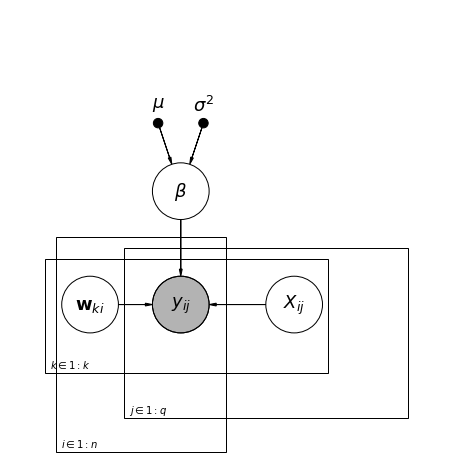

In [2]:
pgm = daft.PGM(shape=[4, 4], origin=[0, 0], grid_unit=4,
               label_params={'fontsize':18}, observed_style='shaded')
# observed data
pgm.add_node(daft.Node("y", r"$y_{ij}$", 1.5, 1.4, scale=2, observed=True))
pgm.add_node(daft.Node("w", r"$\mathbf{w}_{ki}$", 0.7, 1.4, scale=2))
# individual items plate
pgm.add_plate(daft.Plate([1, 0.5, 2.5, 1.4], label=r"$j \in 1:q$", 
                         shift=-0.1))
pgm.add_plate(daft.Plate([0.4, 0.6, 1.5, 1.4], label=r"$i \in 1:n$", 
                         shift=-0.5))
pgm.add_plate(daft.Plate([0.3, 1.3, 2.5, .5], label=r"$k \in 1:k$", 
                         shift=-0.5))
# pooled beta (latent parameters)
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2.4, scale=2))
pgm.add_node(daft.Node("beta_mu", r"$\mu$", 1.3, 3, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_node(daft.Node("beta_sd", r"$\sigma^{2}$", 1.7, 3, scale=2,
                       fixed=True, offset=(0,6)))
# pooled measurement error
pgm.add_node(daft.Node("X", r"$X_{ij}$", 2.5, 1.4, scale=2))
# draw directed edges
pgm.add_edge("beta_mu", "beta")
pgm.add_edge("beta_sd", "beta")
pgm.add_edge("beta", "y")
pgm.add_edge("w", "y")
pgm.add_edge("X", "y")
pgm.render()
plt.show()

In [10]:
# fix random generator seed
np.random.seed(100)

k = 3 # number of sources
n = 50 # number of individuals
q = 100 # number of questions
mu = np.array([-5, 0, 5]) # sources mean
W = np.random.randn(k,n) # beta coefficients

# generate signal
X = np.random.randn(q,k)
for i,value in enumerate(mu):
    X[:,i] = mu[i] + X[:,i]

# define how probability judgments are generated
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(x, beta) + alpha))

# generate opinions
Y = logistic(X, W)

# remove data points
#for i in range(int(.1*q)):
#    for j in range(int(.1*n)):
#        Y[np.random.randint(q),np.random.randint(n)] = -999
#        
#Y = np.ma.masked_values(Y,value=-999)

Plot sources signal distribution X.

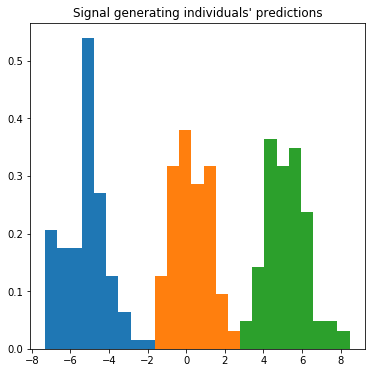

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.hist(X, bins=25, histtype="stepfilled", normed=True)
plt.title("Signal generating individuals' predictions")
plt.show()

Plot individual weights that have to be recovered.

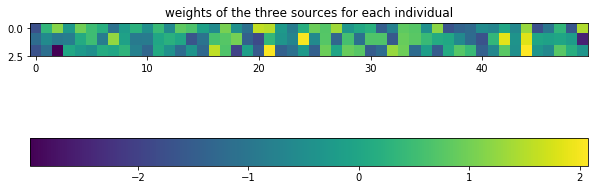

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(W)
plt.colorbar(orientation='horizontal')
plt.title("weights of the three sources for each individual")
plt.show()

Plot individual predictions.

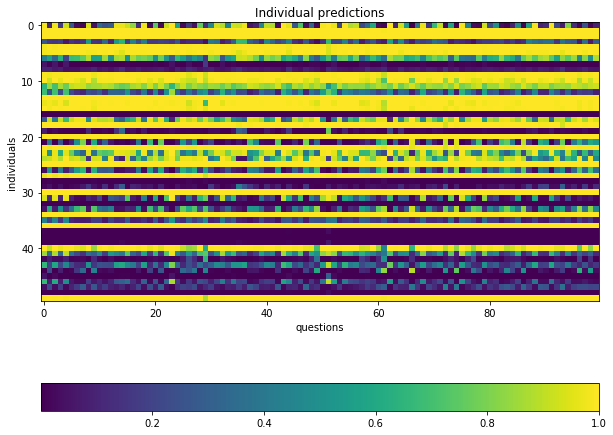

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(Y.T)
plt.colorbar(orientation='horizontal')
plt.title("Individual predictions")
ax.set_ylabel('individuals')
ax.set_xlabel('questions')
plt.show()

Define model, losely based on the graphical model shown in Figure 1

In [ ]:
Y

In [31]:
def logpymc3(x, w):
    return 1.0 / (1.0 + tt.exp(tt.dot(x, w))) 
    
with pm.Model() as basic_model:
    # mean and std of sources
    muX = pm.Normal('muX', mu=[0,0,0], tau= .1, shape=3)
    tauX = pm.HalfNormal('tauX', sd=1)
    # priors on sources
    X_ = pm.Normal("X_", mu=muX, tau=tauX, shape=(q,k)) # dims: nquestions * nsources
    
    # Priors for unknown model parameters
    W_ = pm.Normal('W_' , mu=0, tau=.1, shape=(k,n)) # dims: nsources * npeople

    #Expected value of outcomes
    mu = pm.Deterministic("mu", logpymc3(X_,W_))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, tau=.1, observed=Y)

    #draw 500 posterior samples
    start = pm.find_MAP()
    trace = pm.sample(2000, start=start, njobs=78, tune=1000)


Optimization terminated successfully.
         Current function value: 10688.954933
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 10,459:  18%|█▊        | 35576/200000 [00:28<02:13, 1231.96it/s]
Convergence archived at 35600
Interrupted at 35,600 [17%]: Average Loss = 10,477
 56%|█████▋    | 1695/3000 [03:44<01:54, 11.38it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 53 does not match the target. It is 0.556628632749, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
 62%|██████▏   | 1872/3000 [03:58<01:43, 10.85it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 35 does not match the target. It is 0.882022920447, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
 63%|██████▎   | 1903/3000 [04:00<01:06, 16.44it/s]/usr/local/lib/python3.5/di

Compare the actual information sources with the recovered information sources from the model.

In [ ]:
j = 1
print('Real X values for question %d is :\n' %j + str(X[j,:]))
reconstructed = trace['X_'][:,j,i]

fig, ax = plt.subplots(figsize=(10, 10))
plt.title("recovered weights of the three sources for each individual")
for i in range(3):
    ax = plt.subplot(3,2,i+1)
    plt.hist(trace['X_'][:,j,i], bins=25, histtype="stepfilled", normed=True) 
    #ax.set_xlim((-5,15))
    plt.axvline(x=X[j,i], ymin=0., ymax = 1, linewidth=2, color='r',label='true')
    plt.axvline(x=np.mean(trace['X_'][:,j,i]), ymin=0., ymax = 1, linewidth=2, color='k')
    plt.title('Source %d' %i)
    
plt.legend()
plt.show()

In [ ]:
# real sources
for i in range(3):
    ax = plt.subplot(3,2,np.ravel_multi_index((i,0),(3,2))+1)
    plt.hist(X[:,i], bins=25, histtype="stepfilled", normed=True) 
    ax.set_xlim((-10,10))
    plt.title('source %d' %i)
plt.xlabel("Real values")

for i in range(3):
    ax = plt.subplot(3,2,np.ravel_multi_index((i,1),(3,2))+1)
    plt.hist(trace['X_'][::3,:,i], bins=25, histtype="stepfilled", normed=True, label='source%d'%i) 
    ax.set_xlim((-10,10))
    plt.title('source %d' %i)
plt.xlabel("Recovered weights")
plt.subplots_adjust(hspace=.5)
plt.show()

In [ ]:
#plt.hist(trace["W_"], bins=10, histtype="stepfilled", normed=True)
W_hat = np.mean(trace["W_"], axis=0)

# real weights
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(W, vmin=-2.5, vmax=2.5)
#plt.colorbar(orientation='horizontal')
plt.title("weights of the three sources for each individual")
plt.show()

# recovered weights
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(W_hat, vmin=-2.5, vmax=2.5)
plt.colorbar(orientation='horizontal')
plt.title("recovered weights of the three sources for each individual")
plt.show()

In [ ]:
plt.scatter(W.ravel(),W_hat.ravel())
r = pearsonr(W.ravel(),W_hat.ravel())
plt.title('R = %.2f , p = %.4f' %(r[0], r[1]))
plt.xlabel('Real weights')
plt.ylabel('Recovered weights')
plt.show()

Compare the actual X values with the recovered X values from the model.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(W_hat[0,:],W_hat[1,:],W_hat[2,:],linewidths=2)
ax.scatter(0,0,0,c='r',depthshade=True)
ax.set_xlabel('W1')
ax.set_ylabel('W2')
ax.set_zlabel('W3')
plt.show()

In [27]:
ns = tt.zeros(3)
ns

Alloc.0

In [ ]:
#pm.plots.traceplot(trace=trace, varnames=["W_"])
#pm.plots.plot_posterior(trace=trace["W_"][:,0])
#pm.plots.plot_posterior(trace=trace["W_"][:,1])
#pm.plots.plot_posterior(trace=trace["W_"][:,3])
#pm.plots.autocorrplot(trace=trace, varnames=["W_"]);

In [ ]:
.9**2*2